El siguiente codigo fue hecho por nosotros y fue reordenado por Gemini para mejor organizacion (Se crearon funciones para agrupar algunas cosas y se movieron algunas celdas)

# Fase 1: Configuracion del Entorno

In [1]:
%pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [2]:
import contractions
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
from nltk.corpus import stopwords
from wordcloud import WordCloud
import seaborn as sns
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Fase 2: Carga y Parseo de Datos

In [3]:
def parse_chatlog(xml_file_path):
    # lee el archivo xml
    with open(xml_file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # envuelve el contenido del body con cdata para preservar caracteres
    content_cdata = re.sub(
        r'<BODY>(.*?)</BODY>',
        r'<BODY><![CDATA[\1]]></BODY>',
        content,
        flags=re.DOTALL | re.IGNORECASE
    )

    # parsea el contenido modificado
    root = ET.fromstring(content_cdata)

    # extrae usernames de predadores y victimas
    predator_usernames = {sn.findtext('USERNAME') for sn in root.findall('.//PREDATOR/SCREENNAME')}
    victim_usernames = {sn.findtext('USERNAME') for sn in root.findall('.//VICTIM/SCREENNAME')}

    # itera sobre los posts para extraer datos
    posts = []
    for post in root.findall('.//POST'):
        username = post.findtext("USERNAME")
        if not username or not username.strip():
            continue

        username = username.strip()
        role = 'predator' if username in predator_usernames else 'victim' if username in victim_usernames else 'desconocido'

        post_data = {
            'username': username,
            'datetime': post.findtext("DATETIME"),
            'body': post.findtext('BODY', default='').strip(),
            'role': role
        }
        posts.append(post_data)

    return pd.DataFrame(posts)

In [4]:
folder_path = "GeneralData"
all_dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".xml"):
        full_path = os.path.join(folder_path, filename)
        df = parse_chatlog(full_path)
        if not df.empty:
            df['file'] = filename
            all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)

print("--- Dataframe cargado ---")
combined_df.info()
print("\n--- Primeras 5 filas ---")
combined_df.head()

--- Dataframe cargado ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77422 entries, 0 to 77421
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  77422 non-null  object
 1   datetime  77422 non-null  object
 2   body      77422 non-null  object
 3   role      77422 non-null  object
 4   file      77422 non-null  object
dtypes: object(5)
memory usage: 3.0+ MB

--- Primeras 5 filas ---


,username,datetime,body,role,file
0,armysgt1961,(7:02:01 pm),im dennis us army soldier from cincinnati,predator,ArmySgt1961.xml
1,peekaboo1293,(7:02:30 pm),hi im becky from ky,victim,ArmySgt1961.xml
2,armysgt1961,(7:02:35 pm),how old ru,predator,ArmySgt1961.xml
3,peekaboo1293,(7:02:42 pm),13 how old ru,victim,ArmySgt1961.xml
4,armysgt1961,(7:02:44 pm),u single,predator,ArmySgt1961.xml


# Fase 3: Preprocesamiento y Limpieza de Datos

### 3.1 Normalizacion de Texto

In [5]:
replacement_mapping = {
    # abreviaturas y slang
    "luv": "love", "doin": "doing", "ya": "you", "yr": "your", "ur": "your",
    "idk": "i don't know", "btw": "by the way", "thx": "thanks", "pls": "please",
    "plz": "please", "omg": "oh my god", "lol": "laughing out loud", "lmao": "laughing my ass off",
    "wtf": "what the fuck", "wth": "what the hell", "omw": "on my way", "l8r": "later",
    "gr8": "great", "msg": "message", "txt": "text", "pic": "picture", "ttyl": "talk to you later",
    "brb": "be right back", "afk": "away from keyboard", "bf": "boyfriend", "gf": "girlfriend",
    "wanna": "want to", "gonna": "going to", "gotta": "got to", "cuz": "because", "coz": "because",
    "tho": "though", "dat": "that", "da": "the", "dis": "this", "dem": "them",
    "ain't": "is not", "gotcha": "got you", "sorta": "sort of", "kinda": "kind of",
    "dunno": "don't know", "tryna": "trying to", "lemme": "let me", "gimme": "give me",
    "whatcha": "what are you", "getin": "getting", "gtg": "got to go", "comdom": "condom",
    "preggerz": "pregnant", "min": "minutes", "scard": "scared", "hafta": "have to",
    "prof": "profile", "promis": "promise", "callin": "calling", "hav": "have",
    "sooo": "so", "yeah": "yes",
    # combinaciones de letras y numeros
    "me2": "me too", "u2": "you too", "2day": "today", "b4": "before", "4u": "for you",
    "2nite": "tonight", "2moro": "tomorrow", "4ever": "forever", "4get": "forget",
    "1der": "wonder", "1st": "first", "cu": "see you", "c u": "see you", "cya": "see you",
    # casos especiales (frases cortas o letras sueltas)
    "r u": "are you", "ru": "are you", "im": "i'm", "ill": "i will",
    "k": "ok", "r": "are", "u": "you", "c": "see", "b": "be",
    # correcciones numericas
    "2": "two",
    "4": "four"
}

# crea lista ordenada por longitud para reemplazo correcto
replacement_list = sorted(
    [(rf'\b{pattern}\b', replacement) for pattern, replacement in replacement_mapping.items()],
    key=lambda x: len(x[0]),
    reverse=True
)

def normalize_text(text):
    if not isinstance(text, str):
        return ""

    # a minusculas
    text = text.lower()
    # expandir contracciones
    text = contractions.fix(text)
    # reemplazar slang con lista ordenada
    for pattern, replacement in replacement_list:
        text = re.sub(pattern, replacement, text)
    # limpieza final de caracteres y espacios
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
combined_df['normalized_body'] = combined_df['body'].apply(normalize_text)

print("--- Verificacion de Normalizacion de Texto ---")
print(combined_df[['body', 'normalized_body']].head())

--- Verificacion de Normalizacion de Texto ---
                                        body  \
0  im dennis us army soldier from cincinnati   
1                        hi im becky from ky   
2                                 how old ru   
3                              13 how old ru   
4                                   u single   

                               normalized_body  
0  i am dennis us army soldier from cincinnati  
1                        hi i am becky from ky  
2                              how old are you  
3                           13 how old are you  
4                                   you single  


### 3.2 Procesamiento de Fechas

In [7]:
def preprocess_datetime(series):
    # limpiar parentesis, corchetes y espacios
    clean_series = series.astype(str).str.strip("()[] ")

    # estandarizar am/pm
    clean_series = clean_series.str.replace('a.m.', 'am', regex=False).str.replace('p.m.', 'pm', regex=False)
    clean_series = clean_series.str.replace('A.M.', 'AM', regex=False).str.replace('P.M.', 'PM', regex=False)

    # convertir a datetime, errores se convierten en NaT
    parsed_dates = pd.to_datetime(clean_series, errors='coerce', infer_datetime_format=True)

    return parsed_dates

combined_df['datetime_parsed'] = preprocess_datetime(combined_df['datetime'])

C:\Users\javie\AppData\Local\Temp\ipykernel_18680\2120586220.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed_dates = pd.to_datetime(clean_series, errors='coerce', infer_datetime_format=True)
C:\Users\javie\AppData\Local\Temp\ipykernel_18680\2120586220.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed_dates = pd.to_datetime(clean_series, errors='coerce', infer_datetime_format=True)
C:\Users\javie\AppData\Local\Temp\ipykernel_18680\2120586220.py:10: FutureWarning: Parsed string "7:47:13 M" included an un-recognized timezone "M". Dropping unrecognized timezones is deprecated; in a future version this will raise. In

In [ ]:
unparsed_count = combined_df['datetime_parsed'].isna().sum()
print(f"Entradas no parseadas (NaT): {unparsed_count}")

print("--- Muestra de resultados ---")
print(combined_df[combined_df['datetime'].notna()][['datetime', 'datetime_parsed']].head())

--- Verificacion de Parseo de Fechas ---
Entradas no parseadas (NaT): 3577
--- Muestra de resultados ---
       datetime     datetime_parsed
0  (7:02:01 pm) 2025-06-21 19:02:01
1  (7:02:30 pm) 2025-06-21 19:02:30
2  (7:02:35 pm) 2025-06-21 19:02:35
3  (7:02:42 pm) 2025-06-21 19:02:42
4  (7:02:44 pm) 2025-06-21 19:02:44


# Fase 4: Ingenieria de Caracteristicas

In [9]:
combined_df['word_length'] = combined_df['normalized_body'].str.split().str.len()

print("--- Verificacion de Longitud de Palabras ---")
print(combined_df[['normalized_body', 'word_length']].head())

--- Verificacion de Longitud de Palabras ---
                               normalized_body  word_length
0  i am dennis us army soldier from cincinnati            8
1                        hi i am becky from ky            6
2                              how old are you            4
3                           13 how old are you            5
4                                   you single            2


# Fase 5: Analisis Exploratorio de Datos (EDA)

### 5.1 Estadisticas Descriptivas y Distribucion de Roles

In [10]:
print("--- Estadisticas Descriptivas ---")
print(combined_df[['word_length']].describe())

print("\n--- Conteo de Mensajes por Rol ---")
role_counts = combined_df['role'].value_counts()
print(role_counts)

--- Estadisticas Descriptivas ---
        word_length
count  77422.000000
mean       5.204102
std        4.982345
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max      190.000000

--- Conteo de Mensajes por Rol ---
role
victim      39596
predator    37826
Name: count, dtype: int64


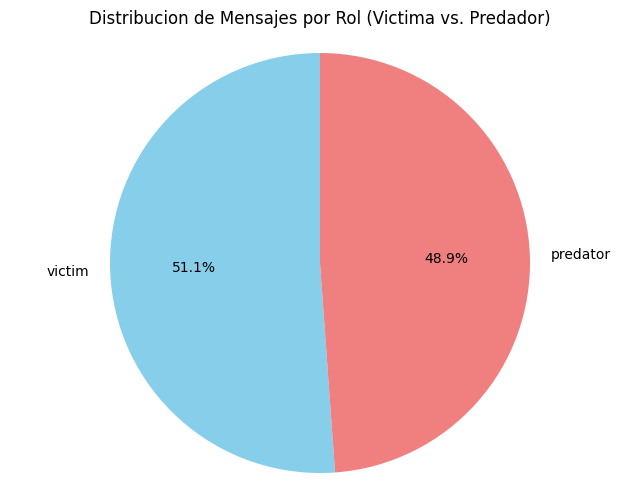

In [11]:
plt.figure(figsize=(8, 6))
pie_data = role_counts[role_counts.index.isin(['victim', 'predator'])]
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Distribucion de Mensajes por Rol (Victima vs. Predador)')
plt.axis('equal')
plt.show()

### 5.2 Analisis de Longitud de Mensajes

C:\Users\javie\AppData\Local\Temp\ipykernel_18680\2433650295.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


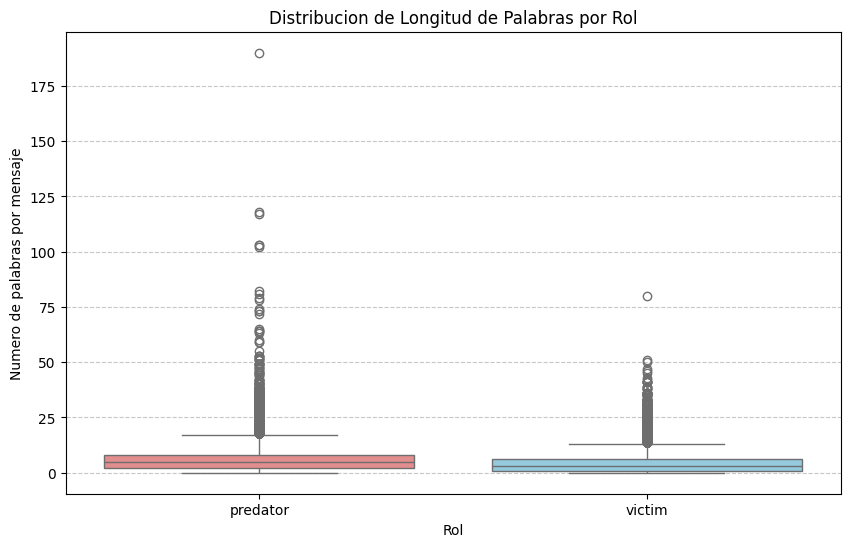

In [12]:
df_filtered = combined_df[combined_df['role'].isin(['victim', 'predator'])]

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='role',
    y='word_length',
    data=df_filtered,
    palette={'victim': 'skyblue', 'predator': 'lightcoral'}
)
plt.title('Distribucion de Longitud de Palabras por Rol')
plt.xlabel('Rol')
plt.ylabel('Numero de palabras por mensaje')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### 5.3 Analisis Temporal

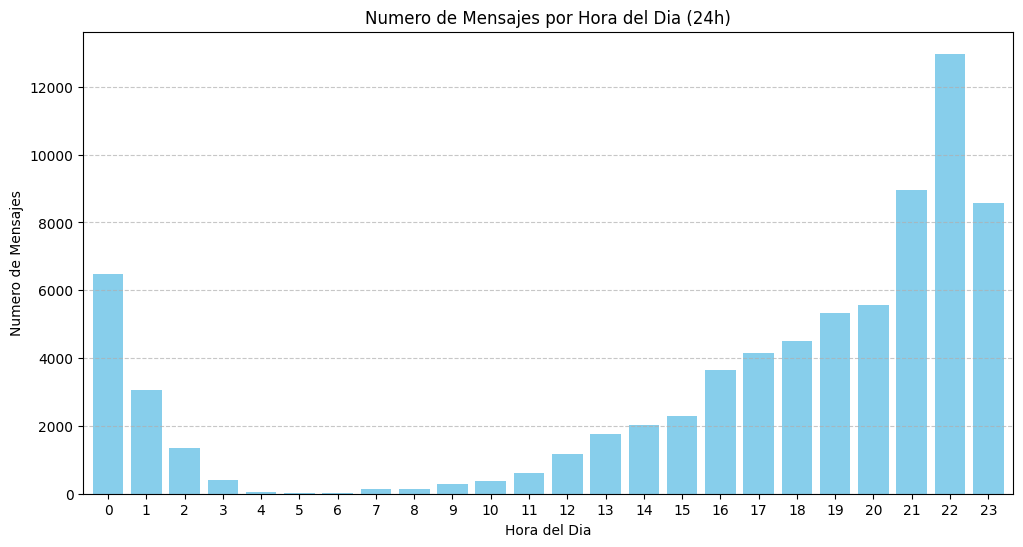

In [13]:
hourly_activity = combined_df.dropna(subset=['datetime_parsed'])['datetime_parsed'].dt.hour.value_counts().sort_index()

plt.figure(figsize=(12, 6))
hourly_activity.plot(kind='bar', color='skyblue', width=0.8)
plt.title('Numero de Mensajes por Hora del Dia (24h)')
plt.xlabel('Hora del Dia')
plt.ylabel('Numero de Mensajes')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 5.4 Nubes de Palabras (Word Clouds)

In [14]:
def plot_wordcloud_for_role(df, role, custom_stopwords=None):
    # usa stopwords estandar en ingles
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)

    # une todo el texto normalizado para el rol especificado
    text = ' '.join(df[df['role'] == role]['normalized_body'].dropna())

    # genera la nube de palabras si hay texto
    if text:
        wordcloud = WordCloud(
            width=1600,
            height=800,
            background_color='white',
            stopwords=stop_words,
            collocations=False
        ).generate(text)

        plt.figure(figsize=(20, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud para rol: {role.capitalize()}", fontsize=24)
        plt.show()
    else:
        print(f"No hay texto disponible para el rol '{role}' para generar un WordCloud.")

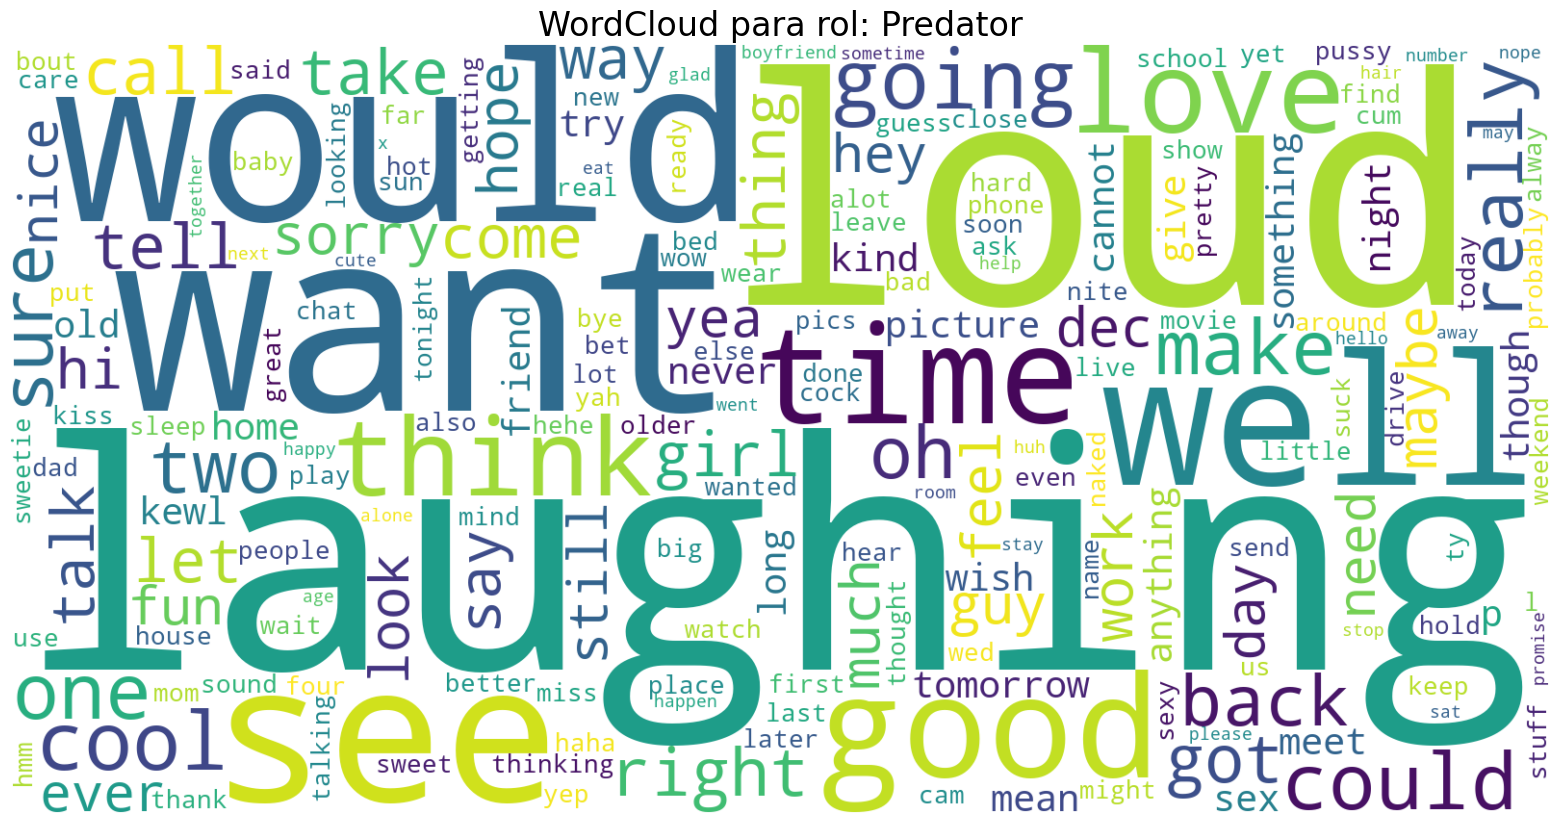

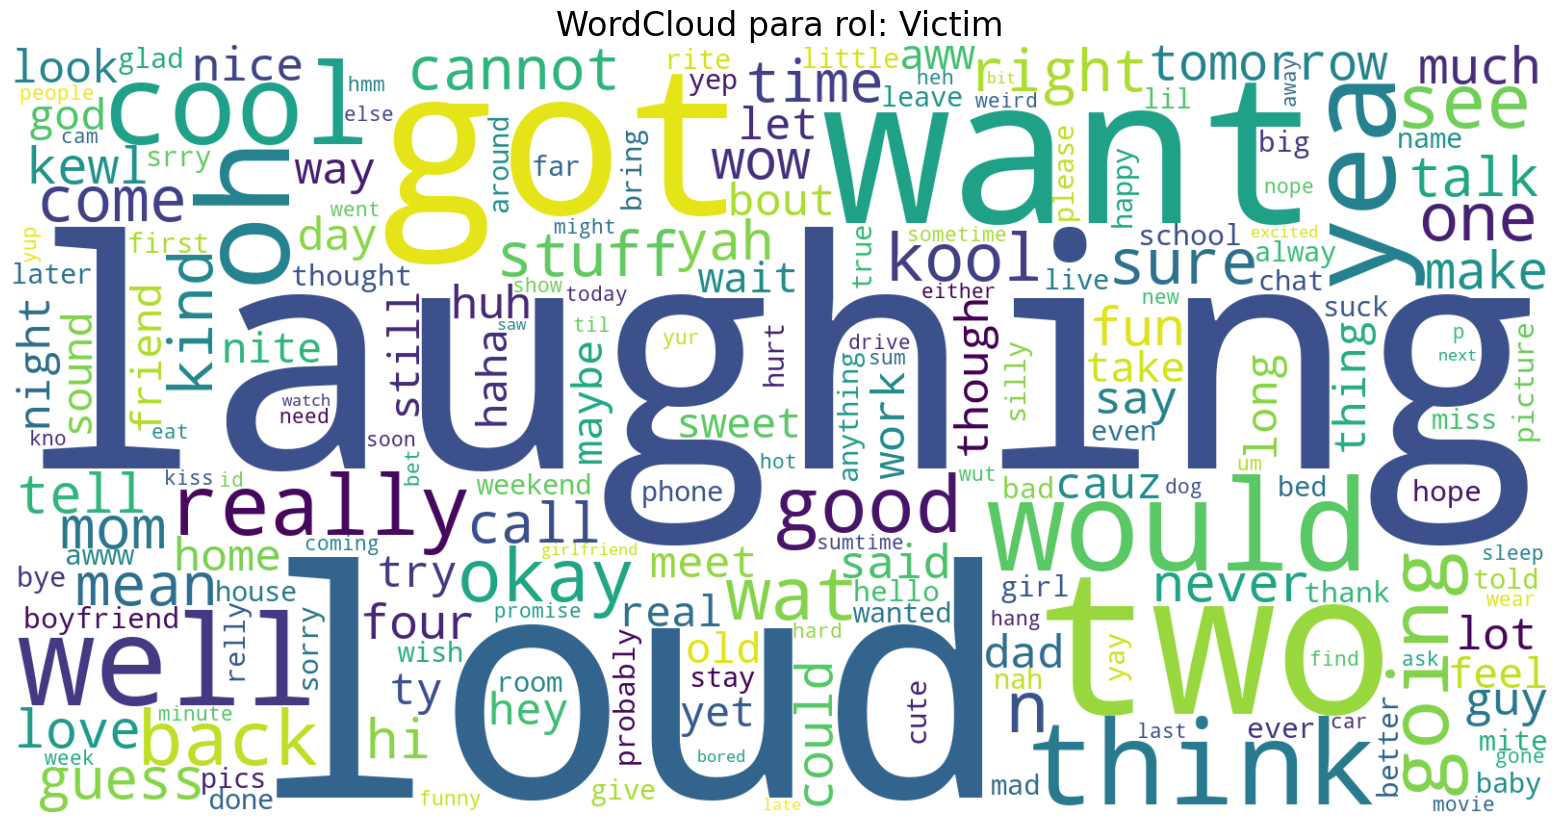

In [15]:
# palabras comunes de chat para excluir de la visualizacion
common_chat_words = ['ok', 'yes', 'yeah', 'no', 'know', 'like', 'get', 'go', 'gonna', 'wanna', 'im', 'am', 'are']

plot_wordcloud_for_role(combined_df, 'predator', custom_stopwords=common_chat_words)
plot_wordcloud_for_role(combined_df, 'victim', custom_stopwords=common_chat_words)

# Fase 6: Preparacion ML

In [78]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [79]:
output_dir = "data_export"
output_file = "cleaned_dataset.feather"
output_path = os.path.join(output_dir, output_file)

os.makedirs(output_dir, exist_ok=True)

# Formato feather preserva tipos de datos en python
combined_df.to_feather(output_path)

print(f"Dataframe exportado a {output_path}")

Dataframe exportado a data_export\cleaned_dataset.feather
